In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyddm


def pdf(t, v, a, z, err=0.001):
    """a>0, z∈[0,a], t>0"""
    tt = t / (a**2)  # normalize time
    w = z / a  # relative start point (0 to 1)

    # kl: number of terms for large t
    if np.pi * tt * err < 1:  # low error threshold
        kl = np.sqrt(-2 * np.log(np.pi * tt * err) / (np.pi**2 * tt))
        kl = max(kl, 1 / (np.pi * np.sqrt(tt)))
    else:  # high error threshold
        kl = 1 / (np.pi * np.sqrt(tt))

    # ks: number of terms for small t
    if 2 * np.sqrt(2 * np.pi * tt) * err < 1:  # low error threshold
        ks = 2 + np.sqrt(-2 * tt * np.log(2 * np.sqrt(2 * np.pi * tt) * err))
        ks = max(ks, np.sqrt(tt) + 1)
    else:  # high error threshold
        ks = 2

    # f(tt|0,1,w)
    if ks < kl:  # small t approximation
        K = int(np.ceil(ks))
        Ks = np.arange(-((K - 1) // 2), ((K - 1) // 2) + 1)
        exponent = -((w + 2 * Ks) ** 2) / (2 * tt)
        p = np.sum((w + 2 * Ks) * np.exp(exponent)) / np.sqrt(2 * np.pi * tt**3)
    else:  # large t approximation
        K = int(np.ceil(kl))
        Ks = np.arange(1, K + 1)
        exponent = -(Ks**2) * (np.pi**2) * tt / 2
        p = np.pi * np.sum(Ks * np.exp(exponent) * np.sin(Ks * np.pi * w))

    # f(t|v,a,w)
    p *= np.exp(-v * a * w - (v**2) * t / 2) / (a**2)

    return p

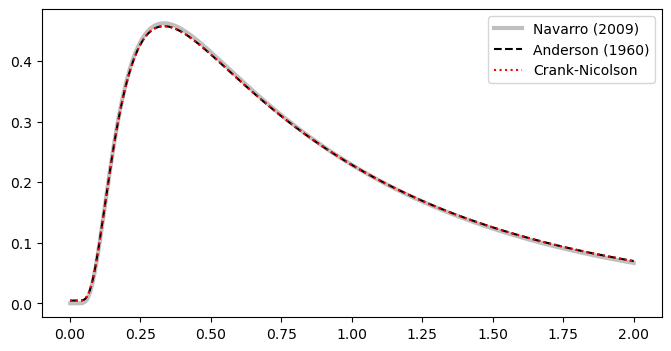

In [2]:
pyddm_params = {"v": 0, "a": 1, "z": 0}
ddm = pyddm.gddm(
    drift=pyddm_params["v"],
    bound=pyddm_params["a"],
    starting_position=pyddm_params["z"],
    nondecision=0,
    noise=1.0,
)

# anderson: ddm -> pdf
and_sol = ddm.solve_analytical()

# crank-nicolson: ddm -> pdf
cn_sol = ddm.solve_numerical_cn()

# navarro: ddm -> pdf
nav_params = {
    "v": pyddm_params["v"],
    "a": 2 * pyddm_params["a"],
    "z": pyddm_params["a"] * (pyddm_params["z"] + 1),
}
ts = np.linspace(0.001, 2, 500)
rts = [pdf(t, **nav_params) for t in ts]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ts, rts, label="Navarro (2009)", lw=3, c="k", alpha=0.25)
ax.plot(and_sol.t_domain, and_sol.pdf(choice="error"), ls="--", c="k", label="Anderson (1960)")
ax.plot(and_sol.t_domain, cn_sol.pdf(choice="error"), ls=":", c="r", label="Crank-Nicolson")
ax.legend()